# Peak to Average Power Ratio in OFDM

In [177]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import lfilter
#import statistics as stats

In [178]:
import json
import math
import numpy as np
from scipy import signal
import h5py
import matplotlib.pyplot as plt
from matplotlib import rc
import datetime
import scipy.signal as signal
import pandas as pd
import seaborn as sns
import statistics as stats
from scipy.spatial.distance import hamming
import os

In [179]:
def text2bits(message):
    # Convert to characters of '1' and '0' in a vector.
    temp_message = []
    final_message = []
    for each in message:
        temp_message.append(format(ord(each), '07b'))
    for every in temp_message:
        for digit in every:
            final_message.append(int(digit))
    return final_message

In [180]:
def binvector2str(binvector):
    #binvector = binvector[0]
    length = len(binvector)
    eps = np.finfo('float').eps
    if abs(length/7 - round(length/7)) > eps:
        print('Length of bit stream must be a multiple of 7 to convert to a string.')
    # Each character requires 7 bits in standard ASCII
    num_characters = round(length/7)
    # Maximum value is first in the vector. Otherwise would use 0:1:length-1
    start = 6
    bin_values = []
    while start >= 0:
        bin_values.append(int(math.pow(2,start)))
        start = start - 1
    bin_values = np.array(bin_values)
    bin_values = np.transpose(bin_values)
    str_out = '' # Initialize character vector
    for i in range(num_characters):
        single_char = binvector[i*7:i*7+7]
        value = 0
        for counter in range(len(single_char)):
            value = value + (int(single_char[counter]) * int(bin_values[counter]))
        str_out += chr(int(value))
    return str_out

In [181]:
packet = 6000 # number of bits per pseudonym bit
samples = packet//10
OFDM_size = 80
CP = 16
#mod_index = 0.0 # decides the level of modification/modulation on the host signal
#const = 0.02 # used to control voltage input to the usrp transmitter
Pseudonym = 'STOP'
Pseudonym_Len = len(text2bits(Pseudonym))

In [182]:
# PURPOSE: Generate an OFMD signal for a given text message
# We use 25% cyclic prefix
def OFDM_TX(x):
    #args = parse_args()
    K = 64 # number of OFDM subcarriers
    P = 4 # number of pilot carriers per OFDM block
    G = 12 # number of guard carriers
    CP = 16  # 25% Cyclic Prefix 
    M = 2 # bits per symbol (i.e. QPSK)
    
    # generate the host message signal
    bits = np.random.binomial(n=1, p=0.5, size=(x*9600,))
    dataCarriers = np.array([-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,
                         -5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
    pilotCarriers = np.array([-21,-7,7,21])
    guardCarriers = np.array([-32,-31,-30,-29,-28,-27,26,27,28,29,30,31])
 
    for i in range(len(bits)//(2*K)):
        
        data_bits = bits[i*2*K:(i+1)*2*K]

        # Convert serial data to parallel
        def Serial_to_Parallel(x):
            return x.reshape((K, M))
        parallel_bits = Serial_to_Parallel(data_bits)

        # mapping table
        ## maps data_bits into complex value IQ samples
        mapping_table = {
            (0,0) : 1.4142 + 1.4142j,
            (0,1) : -1.4142 + 1.4142j,
            (1,0) : 1.4142 - 1.4142j,
            (1,1) : -1.4142 - 1.4142j
        }

        # mapping
        def Mapping(x):
            return np.array([mapping_table[tuple(b)] for b in x])
        
        QPSK = Mapping(parallel_bits)

        # OFDM symbol generation
        def OFDM_symbol_gen(x):
            pilot_value = np.array([1.412+1.4142j, -1.4142-1.4142j, 1.4142+1.4142j, -1.4142-1.4142j])
            guard_band = np.array([0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j])
            
            symbol = np.zeros(K, dtype=np.complex64)
            symbol[dataCarriers] = x[dataCarriers]
            symbol[pilotCarriers] = pilot_value
            symbol[guardCarriers] = guard_band
            return symbol
        OFDM_symbol = OFDM_symbol_gen(QPSK)
        
        # Generate time domain signal
        def IDFT(x, n=64):
            return np.fft.ifftshift(np.fft.ifft(x,n))
        
        OFDM_symbol_time = IDFT(OFDM_symbol)

        #adding cyclic prefix
        def addCP(x):
            cp = x[-CP:]              
            return np.hstack([cp, x]) 
        OFDM_withCP = 3*addCP(OFDM_symbol_time)
        #OFDM_withCP = addCP(OFDM_symbol)
        if i == 0:
            OFDM_swap = OFDM_withCP
        else:
            OFDM_signal = np.hstack([OFDM_swap, OFDM_withCP])
            OFDM_swap = OFDM_signal
    return OFDM_signal

In [183]:
## embedding the message signal on to the host signal
def Pseudonym_embedding(x,message):
    modulated_signal = np.zeros(len(x), dtype=np.complex64)
    for i in range(int(len(x)/packet)):
        OFDM_packet = x[i*packet:(i+1)*packet]
        trancated_signal = np.zeros(len(OFDM_packet), dtype=np.complex64)
        if message[i] == 1.0:
            for j in range(10):
                if j%2 == 0:
                    trancated_signal[j*samples:(j+1)*samples] = (1+mod_index)*OFDM_packet[j*samples:(j+1)*samples]
                else:
                    trancated_signal[j*samples:(j+1)*samples] = (1-mod_index)*OFDM_packet[j*samples:(j+1)*samples]
        else:
            for j in range(10):
                if j%2 == 0:
                    trancated_signal[j*samples:(j+1)*samples] = (1-mod_index)*OFDM_packet[j*samples:(j+1)*samples]
                else:
                    trancated_signal[j*samples:(j+1)*samples] = (1+mod_index)*OFDM_packet[j*samples:(j+1)*samples]
        modulated_signal[i*packet:(i+1)*packet] = trancated_signal
    return modulated_signal

In [184]:
# def Peak2Average_Power_Ratio(x):
#     PAPR = 0.00
#     n = len(x)//packet
#     for i in range(n):
#         data = x[i*OFDM_size:(i+1)*OFDM_size]
#         samp_power = abs(data)**2
#         peak_power = np.max(samp_power)
#         PAPR = PAPR + peak_power/np.mean(samp_power)
#     return PAPR/n

In [185]:
def Peak2Average_Power_Ratio(x):
    samp_power = abs(x)**2
    peak_power = np.max(samp_power)
    
    return peak_power/np.mean(samp_power)

In [186]:
def Distribution_PAPR(n):
    P2APR = []
    for i in range(n):
        OFDM_signal = OFDM_TX(Pseudonym_Len) 

        PAM_modulated_OFDM = Pseudonym_embedding(OFDM_signal,text2bits(Pseudonym))

        P2APR.append(Peak2Average_Power_Ratio(PAM_modulated_OFDM))
        
    return P2APR

In [187]:
def Distribution_PAPR_Unwatermarked(n):
    P2APR = []
    for i in range(n):
        OFDM_signal = OFDM_TX(Pseudonym_Len) 

        PAM_modulated_OFDM = Pseudonym_embedding(OFDM_signal,text2bits(Pseudonym))
        # print("Length of Watermarked OFDM Signal:",lenPAM_modulated_OFDM)
        P2APR.append(Peak2Average_Power_Ratio(PAM_modulated_OFDM[:144000]))
        
    return P2APR

In [188]:
n = 1000
mod_index = 0.0
PAPR00 = Distribution_PAPR_Unwatermarked(n)
mod_index = 0.3
PAPR03 = Distribution_PAPR(n)
mod_index = 0.2
PAPR02 = Distribution_PAPR(n)

# PAPR for Separate Channel Transmission of Pseudonum

In [190]:
'''
Protocol parameters!!!
'''
samples = 600 # number of data samples per pseudonym bit
FFT = 64 # FFT size for extracting IQ sample in each subcarrier
OFDM_size = 80 # OFDM symbol with cyclic prefix
pseudonym_len = 4
pream_length = 352
pattern_sample = samples//10
mess_length = samples*OFDM_size*pseudonym_len 
Frame_length = mess_length + pream_length

In [191]:
pseudonym_packet = np.zeros((pseudonym_len,1)) ## Transmitted pseudonym bit sequence
for i in range(pseudonym_len):
    if i%2 == 0:
        pseudonym_packet[i] = 1

In [192]:
dataCarriers = np.array([-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,
                    -5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])

pseudonymChannel2 = np.array([26])

guardCarriers = np.array([-32,-31,-30,-29,-28,-27,26,27,28,29,30,31])
pilotCarriers = np.array([-21,-7,7,21])
p_bit0_pattern = np.array([0,1,0,1,0,1,0,1,0,1])
p_bit1_pattern = np.array([1,0,1,0,1,0,1,0,1,0])


In [193]:
def OFDM_TX_Subchannel(message_len):
    CP = 16  # 25% Cyclic Prefix 
    M = 2 # bits per symbol (i.e. QPSK)
    
    bits = np.random.binomial(n=1, p=0.5, size=(message_len,))
 
    for i in range(len(bits)//(2*FFT)):
        
        data_bits = bits[i*2*FFT:(i+1)*2*FFT]

        # Convert serial data to parallel
        def Serial_to_Parallel(x):
            return x.reshape((FFT, M))
        parallel_bits = Serial_to_Parallel(data_bits)

        # mapping table
        ## maps data_bits into complex value IQ samples
        mapping_table = {
            (0,0) : 1.4142 + 1.4142j,
            (0,1) : -1.4142 + 1.4142j,
            (1,0) : 1.4142 - 1.4142j,
            (1,1) : -1.4142 - 1.4142j
        }

        # mapping
        def Mapping(x):
            return np.array([mapping_table[tuple(b)] for b in x])
        
        QPSK = Mapping(parallel_bits)
#         print('Length of QSPS',len(QPSK))
        # OFDM symbol generation
        def OFDM_symbol_gen(x):
            pilot_value = np.array([1.4142 + 1.4142j, -1.4142 - 1.4142j, 1.4142 + 1.4142j, -1.4142 - 1.4142j])
            guard_value = np.array([0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j])
            pseudonym_value = np.array([1.4142 + 1.4142j])
            
            symbol = np.zeros(FFT, dtype=np.complex64)
            symbol[dataCarriers] = QPSK[dataCarriers]
            symbol[guardCarriers] = guard_value
            symbol[pilotCarriers] = pilot_value
            symbol[pseudonymChannel2] = pseudonym_value
            return symbol
        
        OFDM_symbol = OFDM_symbol_gen(QPSK)

        # Pseudonym Embedding Scheme
        # Embeds the pseudonyms on to the subcarriers
        
        def Pseudonym_Embedding(x):
            if i < len(bits)//(4*FFT):
                      
                if (i//pattern_sample)%2 == 0: 
#                      
                    x[pseudonymChannel2] = x[pseudonymChannel2]*(1+mod_index) 
                else:
#                    
                    x[pseudonymChannel2] = x[pseudonymChannel2]*(1-mod_index) 
            else:
                if (i//pattern_sample)%2 == 0:
#                     
                    x[pseudonymChannel2] = x[pseudonymChannel2]*(1-mod_index) 
                else:
#                     
                    x[pseudonymChannel2] = x[pseudonymChannel2]*(1+mod_index)
            return x
        
        modulated_OFDM = Pseudonym_Embedding(OFDM_symbol)
        
        # Generate time domain signal
        def IDFT(x, n=64):
            return np.fft.ifft(x,n)
        
        OFDM_time = IDFT(modulated_OFDM)

        # adding cyclic prefix
        def addCP(x):
            cp = x[-CP:]              
            return np.hstack([cp, x]) 
        OFDM_withCP = 3*addCP(OFDM_time)
        if i == 0:
            OFDM_swap = OFDM_withCP
        else:
            OFDM_signal = np.hstack([OFDM_swap, OFDM_withCP])
            OFDM_swap = OFDM_signal
#         print('Length of waveform:',len(OFDM_swap))
    return OFDM_signal

In [194]:
# Computes the Peak to Average Power Ratio for n randomly generate Watermarked OFDM Signals
def Distribution_PAPR_Single(n):
    P2APR = []
    for i in range(n):
        OFDM_signal = OFDM_TX_Subchannel(6*FFT*samples) 
        P2APR.append(Peak2Average_Power_Ratio(OFDM_signal))
        
    return P2APR

In [195]:
mod_index = 1.0
PAPR_Separate = Distribution_PAPR_Single(n)

In [196]:
print('Mean of PAPR for unwatermarked =',np.mean(PAPR00))
print('Mean of PAPR for single subcarrier =',np.mean(PAPR_Separate))

Mean of PAPR for unwatermarked = 11.690396
Mean of PAPR for single subcarrier = 11.784425408824085


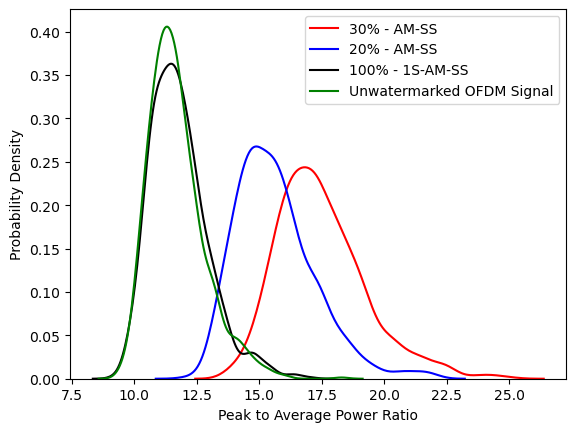

In [197]:
# Plotting the KDE Plot
import seaborn as sns
# creating a dictionary
font = {'size': 10}
 
# using rc function
plt.rc('font', **font)

%matplotlib inline
sns.kdeplot(PAPR03, color='r', fill=False, label='30% - AM-SS')
sns.kdeplot(PAPR02, color='b', fill=False, label='20% - AM-SS')
sns.kdeplot(PAPR_Separate, color='k', fill=False, label='100% - 1S-AM-SS')
sns.kdeplot(PAPR00, color='g', fill=False, label='Unwatermarked OFDM Signal')
plt.legend()
plt.xlabel('Peak to Average Power Ratio', c= 'k')
plt.ylabel('Probability Density', c = 'k')
plt.savefig('PAPR.pdf', format = 'pdf', dpi = 1200)